Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Piotr Durniat"

---

# Zadanie 6 Ewaluacja nienadzorowana

Metody ewaluacji w poprzednim zeszycie opierały się na zastosowaniu reprezentacji w zadaniu docelowym. O ile ten rodzaj ewaluacji stanowi podstawę w przypadku badania jakości nienadzorowanych metod, to ma pewne ograniczenia:
1. Ewaluacja taka może okazać się kosztowna, sczczególnie jeśli sprawdzamy się na dużym zbiorze i chcemy mieć podgląd w trakcie uczenia, np. co epokę
2. Ewaluacja na zadaniu docelowym nie dostarcza nam wszystkich informacji na temat jakości reprezentacji, np. tego czy w pełni wykorzystujemy wszystkie wymiary reprezentacji i model nie wyuczył się redundantnych cech

Ewaluacja reprezentacji w sposób nienadzorowany (nie na zadaniu docelowym) najczęściej korzysta z metod probabilistycznych i/lub algebry liniowej [(Tsitsulin et al., 2023)](https://arxiv.org/pdf/2202.05808.pdf). W niniejszym zeszycie należy zaimplementować dwie metody takiej ewaluacji, przy okazji odświeżając sobie zagadnienia z algebry.

## Zadanie 6.1 (1 pkt)
W pierwszej kolejności sprawdzimy jak mocno reprezentacje uległy zjawisku zapadnięcia się wymiarów (ang. *dimensional collapse*). Do tego wykorzystamy spektrum wartości własnych (ang. *eigenvalues*) macierzy kowariancji. **Wymagane jest pełne zrozumienie istoty takiej ewaluacji, czyli tego czym są macierze, wektory i wartości własne, oraz macierz kowariancji.** W tym celu można skorzystać z serii [Essence of Linear Algebra](https://youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab&si=Zy91Y6-vUxiYOWeQ) i wymienionej powyżej pracy. 

Uzupełnij poniższą funkcję `compute_cov_eig`, która wyliczy spektrum wartości własnych z macierzy kowariancji reprezentacji (posortowane). Czy przed wyznaczeniem macierzy kowariancji należy wycentrować lub ustandaryzować wektory reprezentacji? Zinterpretuj otrzymany wynik.

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import Tensor

In [11]:
def compute_cov_eig(z: Tensor) -> Tensor:
    covariance_matrix = torch.cov(z.t())
    eigenvalues, _ = torch.linalg.eig(covariance_matrix)
    return eigenvalues

/home/piotr/projects/ai/ur-l/l01-sr-17-piotrdurniat/venv/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/piotr/projects/ai/ur-l/l01-sr-17-piotrdurniat/venv/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


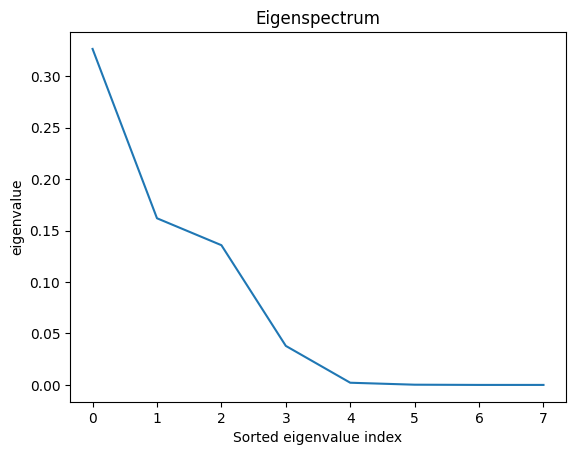

In [13]:
z_train = torch.load("z_train.pt")
eigval_spectrum = compute_cov_eig(z_train).cpu().numpy()

eigval_idx = np.arange(len(eigval_spectrum))
ax = sns.lineplot(x=eigval_idx, y=eigval_spectrum)
ax.set(xlabel="Sorted eigenvalue index", ylabel="eigenvalue", title="Eigenspectrum")
plt.show()

## Zadanie 6.3 (0.5 pkt)

Wyżej otrzymane spektrum może posłużyć analizie i porównaniom różnych reprezentacji. Często jednak zamiast spektrum chcielibyśmy otrzymać pojedynczą wartość jako miarę jakości reprezentacji. Przykładowo powyższą krzywą można dopasować do rokładu *power-law* ($\lambda_j \propto j^{-\alpha},$ gdzie $\lambda_j$ jest $j$-tą wartością własną, a $\alpha$ współczynnikiem zanikania (ang. *coefficient of decay*)), a otrzymany współczynnik potraktować jako taką miarę [(Gosh et al., 2022)](https://arxiv.org/abs/2202.05808).

Dużo prostszym i jednocześnie skuteczniejszym podejściem jest metoda $\texttt{RankMe}$ [(Garrido et al., 2022)](https://arxiv.org/abs/2210.02885), która pozwala na estymacje rzędu (ang. *rank*) macierzy reprezetacji na podstawie entropii rozkładu wartości osobliwych (ang. *signular values* z metody [*Singular Value Deocomposition (SVD)*](https://en.wikipedia.org/wiki/Singular_value_decomposition)), co sprowadza się do poniższego wzoru:
$$\texttt{RankMe}(\boldsymbol{Z}) = exp \left(- \sum_{k=1}^{min(N, D)} p_klog p_k \right)$$
$$p_k = \frac{\sigma_k(\boldsymbol{Z})}{\lVert \sigma_k(\boldsymbol{Z}) \rVert_1} + \epsilon$$
gdzie
$\boldsymbol{Z}$ - macierz reprezentacji $(N, D)$, $\sigma_k(\boldsymbol{Z}$ - $k$-ta wartość osobliwa, $\epsilon$ - mała wartość dla stabilności obliczeń

Zaimplementuj funkcję `rank_me` wykorzystując powyższy wzór. **Wymagane jest pełne zrozumienie metody, w szczególności pojęć: SVD, entropii oraz rzędu macierzy.**

In [39]:
def rank_me(Z, epsilon=1e-10) -> float:
    singular_values = np.linalg.svd(Z, compute_uv=False)
    p_k = singular_values / np.sum(singular_values) + epsilon

    entropy = -np.sum(p_k * np.log(p_k))
    rank_me_value = np.exp(entropy)

    return rank_me_value

In [40]:
rank_me(z_train)

3.3860104

## Zadanie 6.2 (0.5 pkt)
Wepnij metodę estymacji rzędu w pętli uczenia, tak aby końcowo wykreślić zmianę tej metryki w funkcji epoki:
1. Skopiuj implementacje autokodera z poprzedniego zeszytu i zadbaj o to, aby funkcja `forward` oprócz rekonstrukcji zwracała również reprezentację
2. Dokonaj modyfikacji funkcji `train`, tak aby wyliczała rząd macierzy reprezentacji zwróconej przez funkcję `forward`. Zwróć uwagę, że wykorzystujemy tutaj tylko jedną paczkę (ang. *batch*) danych, co stanowi ułatwienie (w przypadku wielu batch'y w epoce, należałoby zadbać o odpowiednia agregację)
3. Uruchom proces uczenia i sprawdź rezultat. Czy wykres zmian rzędu macierzy w procese uczenia zawsze jest taka sam na przestrzeni kilku uruchomień?

In [41]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import torch


X, y = load_digits(return_X_y=True)
X = X / 16.0  # Każda cecha ma zakres wartości 0-16

X = torch.tensor(X).float()
y = torch.tensor(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [56]:
from torch import nn


class Autoencoder(nn.Module):

    def __init__(self, feature_dim: int, hidden_dim: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, feature_dim),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x)), self.encoder(x)

In [59]:
import torch
from torch.nn import functional as F


def train(
    model: Autoencoder,
    optimizer: torch.optim.Optimizer,
    x: torch.Tensor,
) -> tuple[float, float]:
    model.train()

    optimizer.zero_grad()

    x_rec, z = model(x)
    loss = F.mse_loss(input=x_rec, target=x)

    loss.backward()
    optimizer.step()

    rank = rank_me(z.detach().numpy())

    return loss.item(), rank.item()


def test(model: Autoencoder, x: torch.Tensor) -> float:
    model.eval()

    with torch.no_grad():
        x_rec, _ = model(x)
        loss = F.mse_loss(input=x_rec, target=x)

        return loss.item()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

[Text(0.5, 1.0, 'Representation rank'),
 Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Estimated rank')]

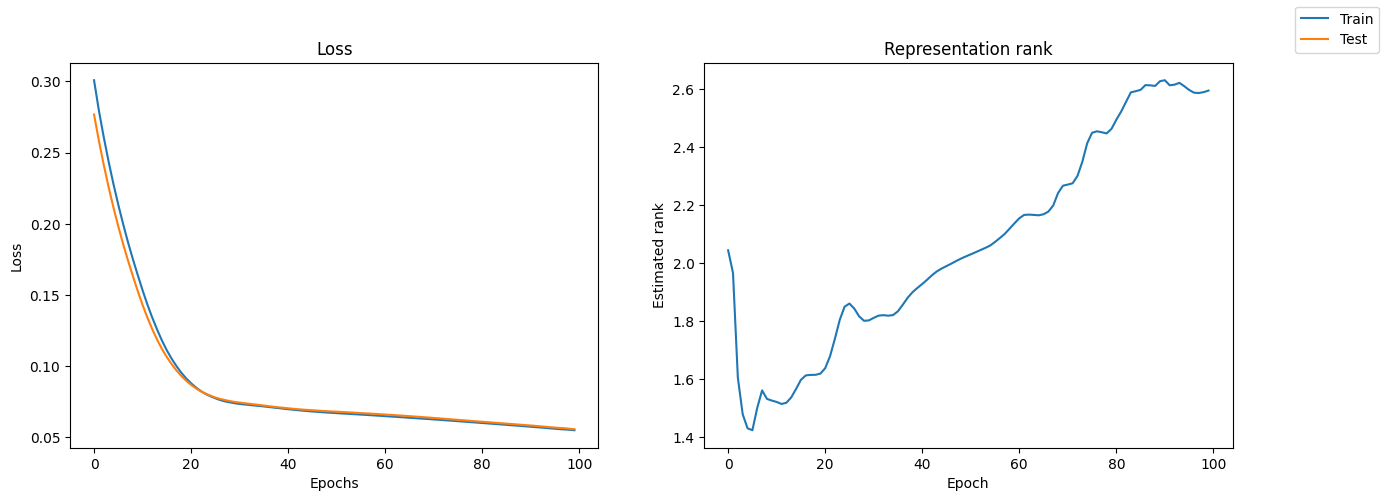

In [60]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

NUM_EPOCHS = 100
REPRESENTATION_DIM = 8


ae = Autoencoder(feature_dim=X.shape[1], hidden_dim=REPRESENTATION_DIM)
opt = torch.optim.Adam(ae.parameters(), lr=1e-2)


train_ranks = []
train_losses = []
test_losses = []

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
ae = ae.to(DEVICE)
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs"):
    X_train = X_train.to(DEVICE)
    X_test = X_test.to(DEVICE)
    train_loss, train_rank = train(model=ae, optimizer=opt, x=X_train)
    test_loss = test(model=ae, x=X_test)

    train_ranks.append(train_rank)
    train_losses.append(train_loss)
    test_losses.append(test_loss)


fig, (ax_loss, ax_rank) = plt.subplots(1, 2, figsize=(15, 5))

ax_loss.plot(train_losses, label="Train")
ax_loss.plot(test_losses, label="Test")
ax_loss.set(title="Loss", xlabel="Epochs", ylabel="Loss")
fig.legend()

ax_rank.plot(train_ranks)
ax_rank.set(title="Representation rank", xlabel="Epoch", ylabel="Estimated rank")